## DGMD S-17 Robotics, Autonomous Vehicles, Drones, and Artificial Intelligence

### Object Detection, Depth Perception and Adaptive Navigation with a Tello Drone

### Group Members: Ryan Abbate, Eumar Assis, Muthukaruppan (Muthu) Annamalai

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

## Load Telemetry data frame

In [26]:
df = pd.read_csv("./assets/telemetry.csv")

print(df.columns)

df.describe()

Index(['log_time', 'Model', 'confidence', 'detected bounding box width',
       'detected bounding box height', 'img xcenter', 'img ycenter',
       'model output xcenter', 'model output ycenter',
       'height (distance to floor)', 'is_flying'],
      dtype='object')


,confidence,detected bounding box width,detected bounding box height,img xcenter,img ycenter,model output xcenter,model output ycenter,height (distance to floor)
count,3.770000e+02,254.000000,254.000000,492.0,492.0,254.000000,254.000000,492.000000
mean,7.436342e+07,487.290166,495.458154,480.0,360.0,302.716502,181.445070,0.243902
std,1.085637e+08,244.381068,183.370317,0.0,0.0,195.276824,168.977774,12.005662
min,2.806100e-01,89.000000,90.000000,480.0,360.0,5.500000,-23.000000,-100.000000
25%,7.910000e-01,253.750000,352.750000,480.0,360.0,145.750000,25.000000,0.000000
50%,9.073048e-01,458.720963,519.000000,480.0,360.0,228.000000,113.000000,0.000000
75%,2.042826e+08,711.033951,684.750000,480.0,360.0,485.981117,360.000000,0.000000
max,2.925508e+08,939.234924,720.000000,480.0,360.0,811.901123,524.035156,80.000000


## 1. Comparing Azure vs. YOLO 

Comparing people detector models

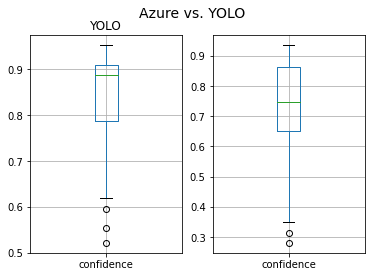

In [40]:
#Get filtered data frames
azure_df = df[df['Model'] =='AzureObjectDetector'] 

yolo_df = df[df['Model'] == 'YOLOObjectDetector']

# Plot two histograms side by side using Matplotlib
fig, axes = plt.subplots(1, 2)

fig.suptitle('Azure vs. YOLO', fontsize=14)

azure_df.boxplot('confidence', ax=axes[0])
axes[0].set_title('Azure')
yolo_df.boxplot('confidence', ax=axes[1])
axes[1].set_title('YOLO')
plt.show()



## 2. Finding person distance from camera

Comparing Computer Vision bounding boxes vs. density